In [2]:
import numpy as np
import pandas as pd
pd.options.mode.copy_on_write = True

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold

In [3]:
## hiding warning
import warnings
from pandas.errors import SettingWithCopyWarning
warnings. simplefilter(action = 'ignore', category = UserWarning)
warnings.filterwarnings(action = 'ignore', category = FutureWarning)
warnings.filterwarnings(action='ignore', category = RuntimeWarning)
warnings.filterwarnings(action='ignore', category = SettingWithCopyWarning)

# looding data

In [5]:
train_df=pd.read_csv("/kaggle/input/playground-series-s5e4/train.csv")
train_df

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031
...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,Learning Lab,Episode 25,75.66,Education,69.36,Saturday,Morning,NaN,0.0,Negative,56.87058
749996,749996,Business Briefs,Episode 21,75.75,Business,35.21,Saturday,Night,NaN,2.0,Neutral,45.46242
749997,749997,Lifestyle Lounge,Episode 51,30.98,Lifestyle,78.58,Thursday,Morning,84.89,0.0,Negative,15.26000
749998,749998,Style Guide,Episode 47,108.98,Lifestyle,45.39,Thursday,Morning,93.27,0.0,Negative,100.72939


## preparing Data sets

# EDA

In [7]:
num_cols=train_df.select_dtypes(include=['number']).columns
cat_cols=train_df.select_dtypes(exclude=['number']).columns
print(len(num_cols))
print(len(cat_cols))

6
6


## Numerical data

### filling null values

In [8]:
## percentage of null values
null_percentage=train_df.isna().sum()/len(train_df)*100

null_status=pd.DataFrame({'null_percentage':null_percentage})
null_status

,null_percentage
id,0.000000
Podcast_Name,0.000000
Episode_Title,0.000000
Episode_Length_minutes,11.612400
Genre,0.000000
Host_Popularity_percentage,0.000000
Publication_Day,0.000000
Publication_Time,0.000000
Guest_Popularity_percentage,19.470667
Number_of_Ads,0.000133


In [9]:
# two cols demonstrate the status of this feilds is imputed its null value(1) or it is anatural value (0)
# train_df["ELM is Imputed ?"]=train_df['Episode_Length_minutes'].isna().astype('int')
# train_df["Guest_Popularity is Imputed ?"]=train_df['Guest_Popularity_percentage'].isna().astype('int')

In [10]:
group_cols = ['Podcast_Name', 'Genre', 'Episode_Title', 'Publication_Day', 'Publication_Time']
while train_df.isnull().sum().sum()>0:

# Fill Episode_Length_minutes by the group mean
  train_df['Episode_Length_minutes' ] = train_df['Episode_Length_minutes'].fillna(
  train_df.groupby(group_cols)['Episode_Length_minutes']
  .transform('mean')
   )

# Fill Guest_Popularity_percentage by the group mean
  # Corrected the typo in the column name from 'Guest_Popylarity_percentage' to 'Guest_Popularity_percentage'
  train_df['Guest_Popularity_percentage'] = train_df['Guest_Popularity_percentage'].fillna(
  train_df.groupby(group_cols)['Guest_Popularity_percentage']
  .transform('mean')
  )

  group_cols.pop()
  if len(group_cols) == 0: break

# Iterate only through numeric columns to fill remaining nulls with the mean
num_cols_remaining_nulls = train_df.select_dtypes(include=['number']).columns[train_df.select_dtypes(include=['number']).isnull().any()]
for col in num_cols_remaining_nulls:
  if train_df[col].isnull().sum()>0:
      train_df[col]=train_df[col].fillna(train_df[col].mean())

In [6]:
null_percentage=train_df.isna().sum()/len(train_df)
null_status=pd.DataFrame({'null_percentage':null_percentage})
null_status

,null_percentage
id,0.000000
Podcast_Name,0.000000
Episode_Title,0.000000
Episode_Length_minutes,0.116124
Genre,0.000000
Host_Popularity_percentage,0.000000
Publication_Day,0.000000
Publication_Time,0.000000
Guest_Popularity_percentage,0.194707
Number_of_Ads,0.000001


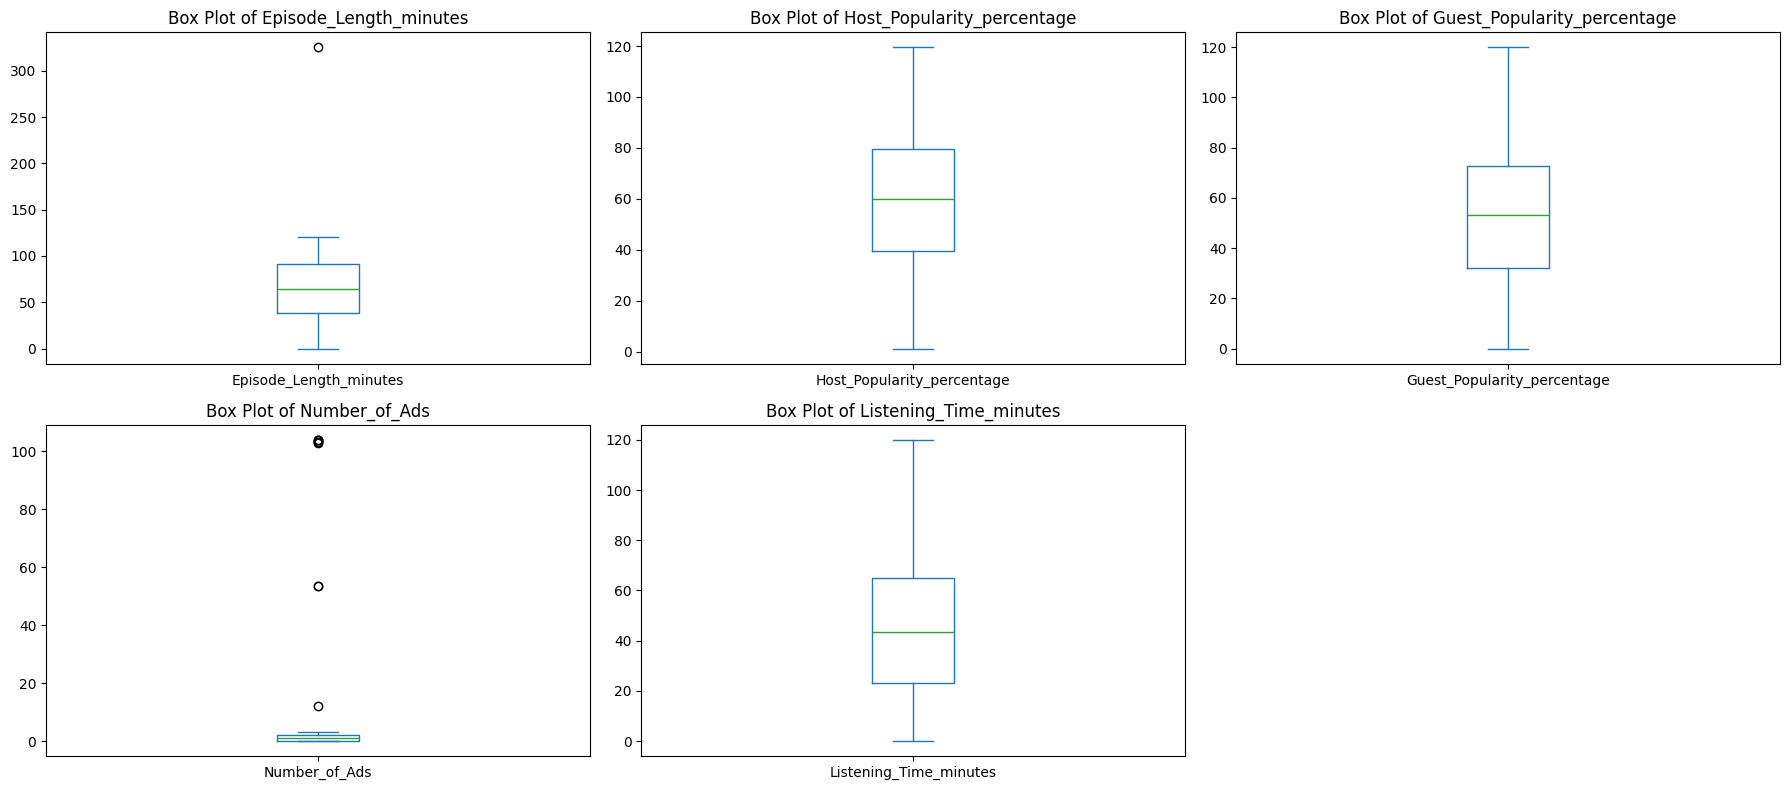

In [12]:
num_cols_no_id = [col for col in num_cols if col != 'id']

n_cols = 3  # Number of columns in the subplot grid
n_rows = (len(num_cols_no_id) + n_cols - 1) // n_cols # Calculate number of rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
axes = axes.flatten() # Flatten the axes array for easy indexing

for i, col in enumerate(num_cols_no_id):
    train_df[[col]].plot(kind='box', ax=axes[i]) # Pass only the column to plot
    axes[i].set_title(f'Box Plot of {col}')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout() # Adjust layout to prevent overlapping
plt.show()

In [13]:
# the non logic imputaion because the [Listening_Time_minutes]
#   isimputed with a value bigger than the actual time of the eposide which is [Episode_Length_minutes]
# For example, merge the 'Listening_Time_minutes' from train_train_df into train_df
filtered_train_df=train_df[train_df['Episode_Length_minutes']<train_df['Listening_Time_minutes']]
ids_to_remove = filtered_train_df['id']

# Step 3: Drop rows from train_df where 'id' is in ids_to_remove
train_df = train_df[~train_df['id'].isin(ids_to_remove)]

In [7]:
train_df

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031
...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,Learning Lab,Episode 25,75.66,Education,69.36,Saturday,Morning,NaN,0.0,Negative,56.87058
749996,749996,Business Briefs,Episode 21,75.75,Business,35.21,Saturday,Night,NaN,2.0,Neutral,45.46242
749997,749997,Lifestyle Lounge,Episode 51,30.98,Lifestyle,78.58,Thursday,Morning,84.89,0.0,Negative,15.26000
749998,749998,Style Guide,Episode 47,108.98,Lifestyle,45.39,Thursday,Morning,93.27,0.0,Negative,100.72939


### handelling outliers

In [8]:
train_df['Number_of_Ads'].value_counts()

Number_of_Ads
0.00      217592
1.00      214069
3.00      160173
2.00      158156
103.25         2
53.37          1
103.91         1
103.00         1
53.42          1
103.75         1
12.00          1
103.88         1
Name: count, dtype: int64

In [16]:
train_df=train_df[train_df['Number_of_Ads']<4]

In [17]:
def get_outlier_bounds(train_df, column):
    q1 = train_df[column].quantile(0.25)
    q3 = train_df[column].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return lower, upper

In [18]:
lower, upper = get_outlier_bounds(train_df, 'Episode_Length_minutes')
train_df['Episode_Length_minutes'] = train_df['Episode_Length_minutes'].clip(lower, upper)


In [9]:
train_df['Episode_Length_minutes'].value_counts()

Episode_Length_minutes
6.600000     925
34.400000    617
30.690000    576
31.680000    533
31.460000    491
            ... 
14.498053      1
8.115479       1
93.660301      1
98.298620      1
62.167294      1
Name: count, Length: 12268, dtype: int64

### visualizing numerical colunms

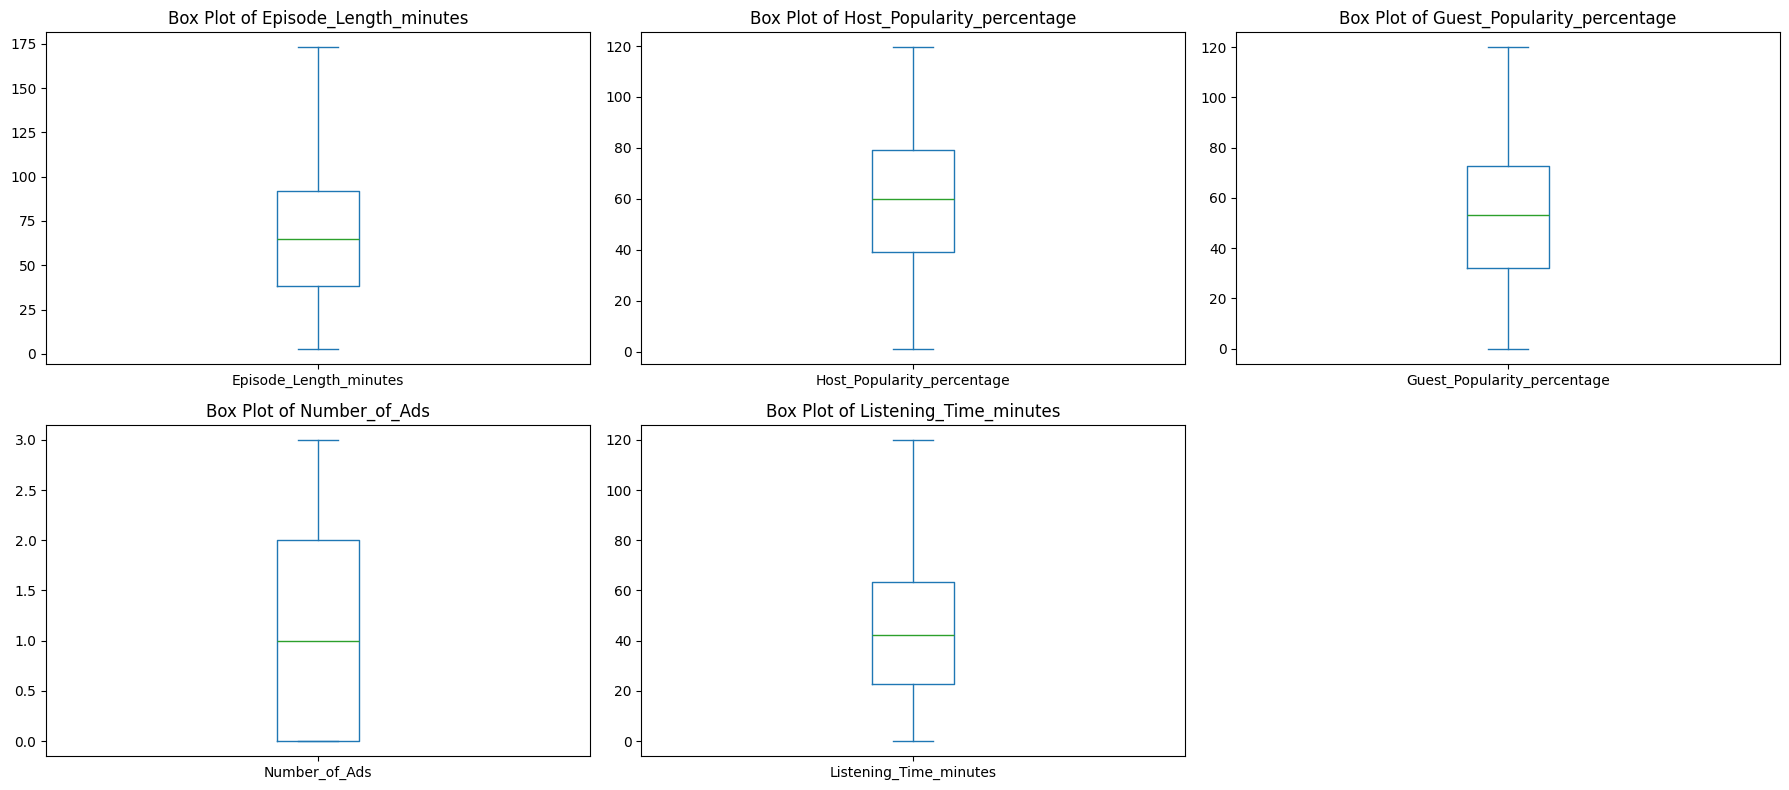

In [20]:
num_cols_no_id = [col for col in num_cols if col != 'id']

n_cols = 3  # Number of columns in the subplot grid
n_rows = (len(num_cols_no_id) + n_cols - 1) // n_cols # Calculate number of rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
axes = axes.flatten() # Flatten the axes array for easy indexing

for i, col in enumerate(num_cols_no_id):
    train_df[[col]].plot(kind='box', ax=axes[i]) # Pass only the column to plot
    axes[i].set_title(f'Box Plot of {col}')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout() # Adjust layout to prevent overlapping
plt.show()

In [10]:
train_df.describe()

,id,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes
count,750000.000000,662907.000000,750000.000000,603970.000000,749999.000000,750000.000000
mean,374999.500000,64.504738,59.859901,52.236449,1.348855,45.437406
std,216506.495284,32.969603,22.873098,28.451241,1.151130,27.138306
min,0.000000,0.000000,1.300000,0.000000,0.000000,0.000000
25%,187499.750000,35.730000,39.410000,28.380000,0.000000,23.178350
50%,374999.500000,63.840000,60.050000,53.580000,1.000000,43.379460
75%,562499.250000,94.070000,79.530000,76.600000,2.000000,64.811580
max,749999.000000,325.240000,119.460000,119.910000,103.910000,119.970000


array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'Episode_Length_minutes'}>],
       [<Axes: title={'center': 'Host_Popularity_percentage'}>,
        <Axes: title={'center': 'Guest_Popularity_percentage'}>],
       [<Axes: title={'center': 'Number_of_Ads'}>, <Axes: >]],
      dtype=object)

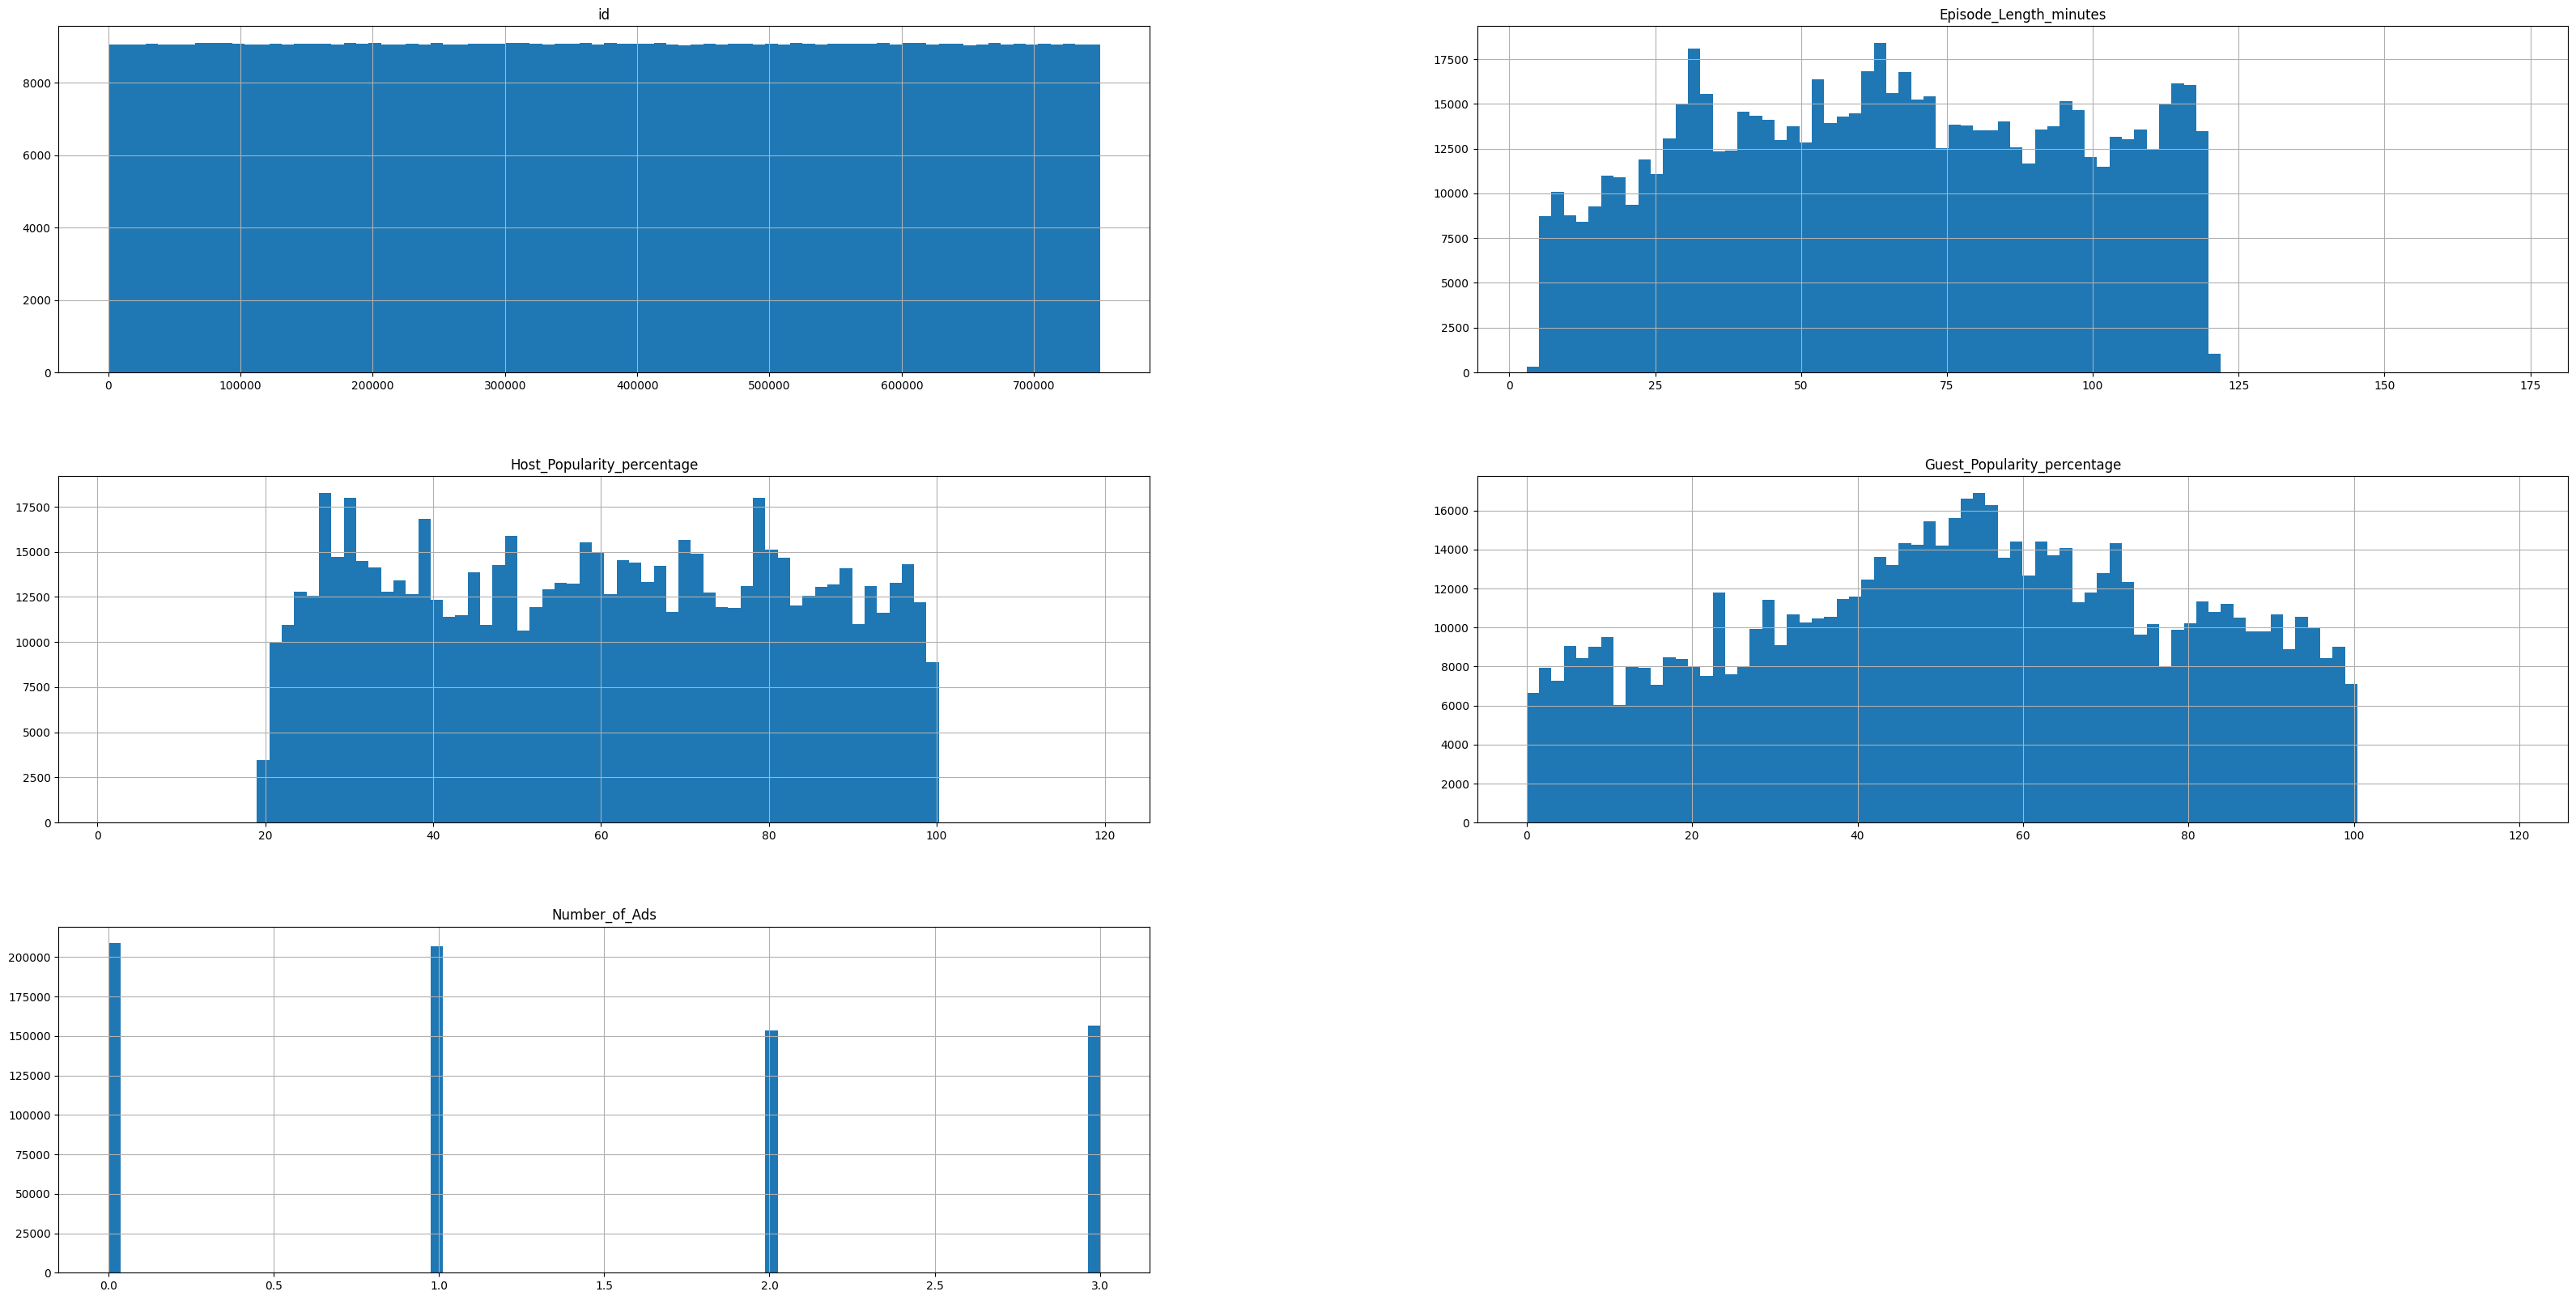

In [22]:
train_df[num_cols[:5]].hist(bins =80, figsize = (40,20))

In [23]:
train_df.columns

Index(['id', 'Podcast_Name', 'Episode_Title', 'Episode_Length_minutes',
       'Genre', 'Host_Popularity_percentage', 'Publication_Day',
       'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads',
       'Episode_Sentiment', 'Listening_Time_minutes'],
      dtype='object')

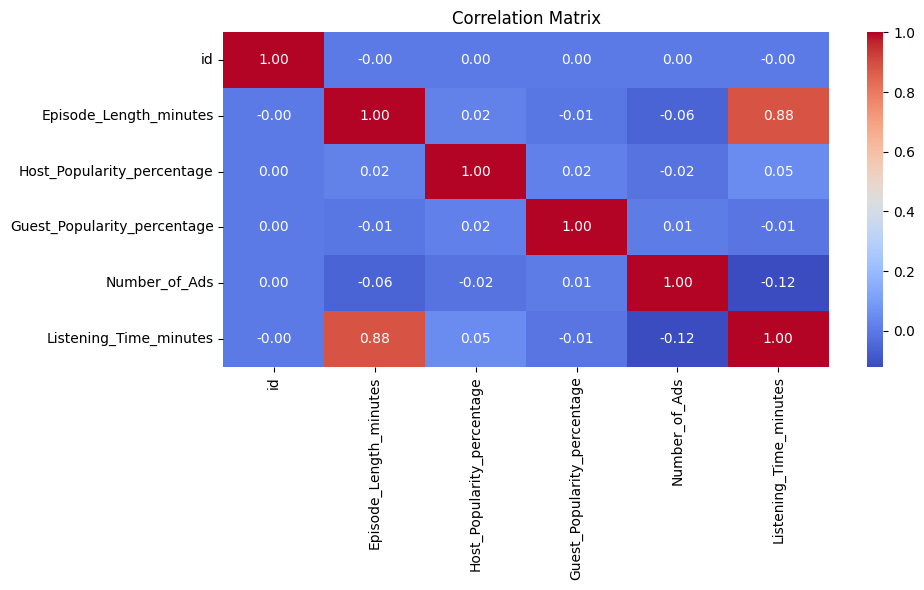

In [24]:
#visualizeing correlation
plt.figure(figsize=(10, 6))
sns.heatmap(train_df[num_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

## Catigorical data

In [25]:
train_df_list=[]
for cat_column in cat_cols:
    train_df_list.append(train_df)
len(train_df_list)

6

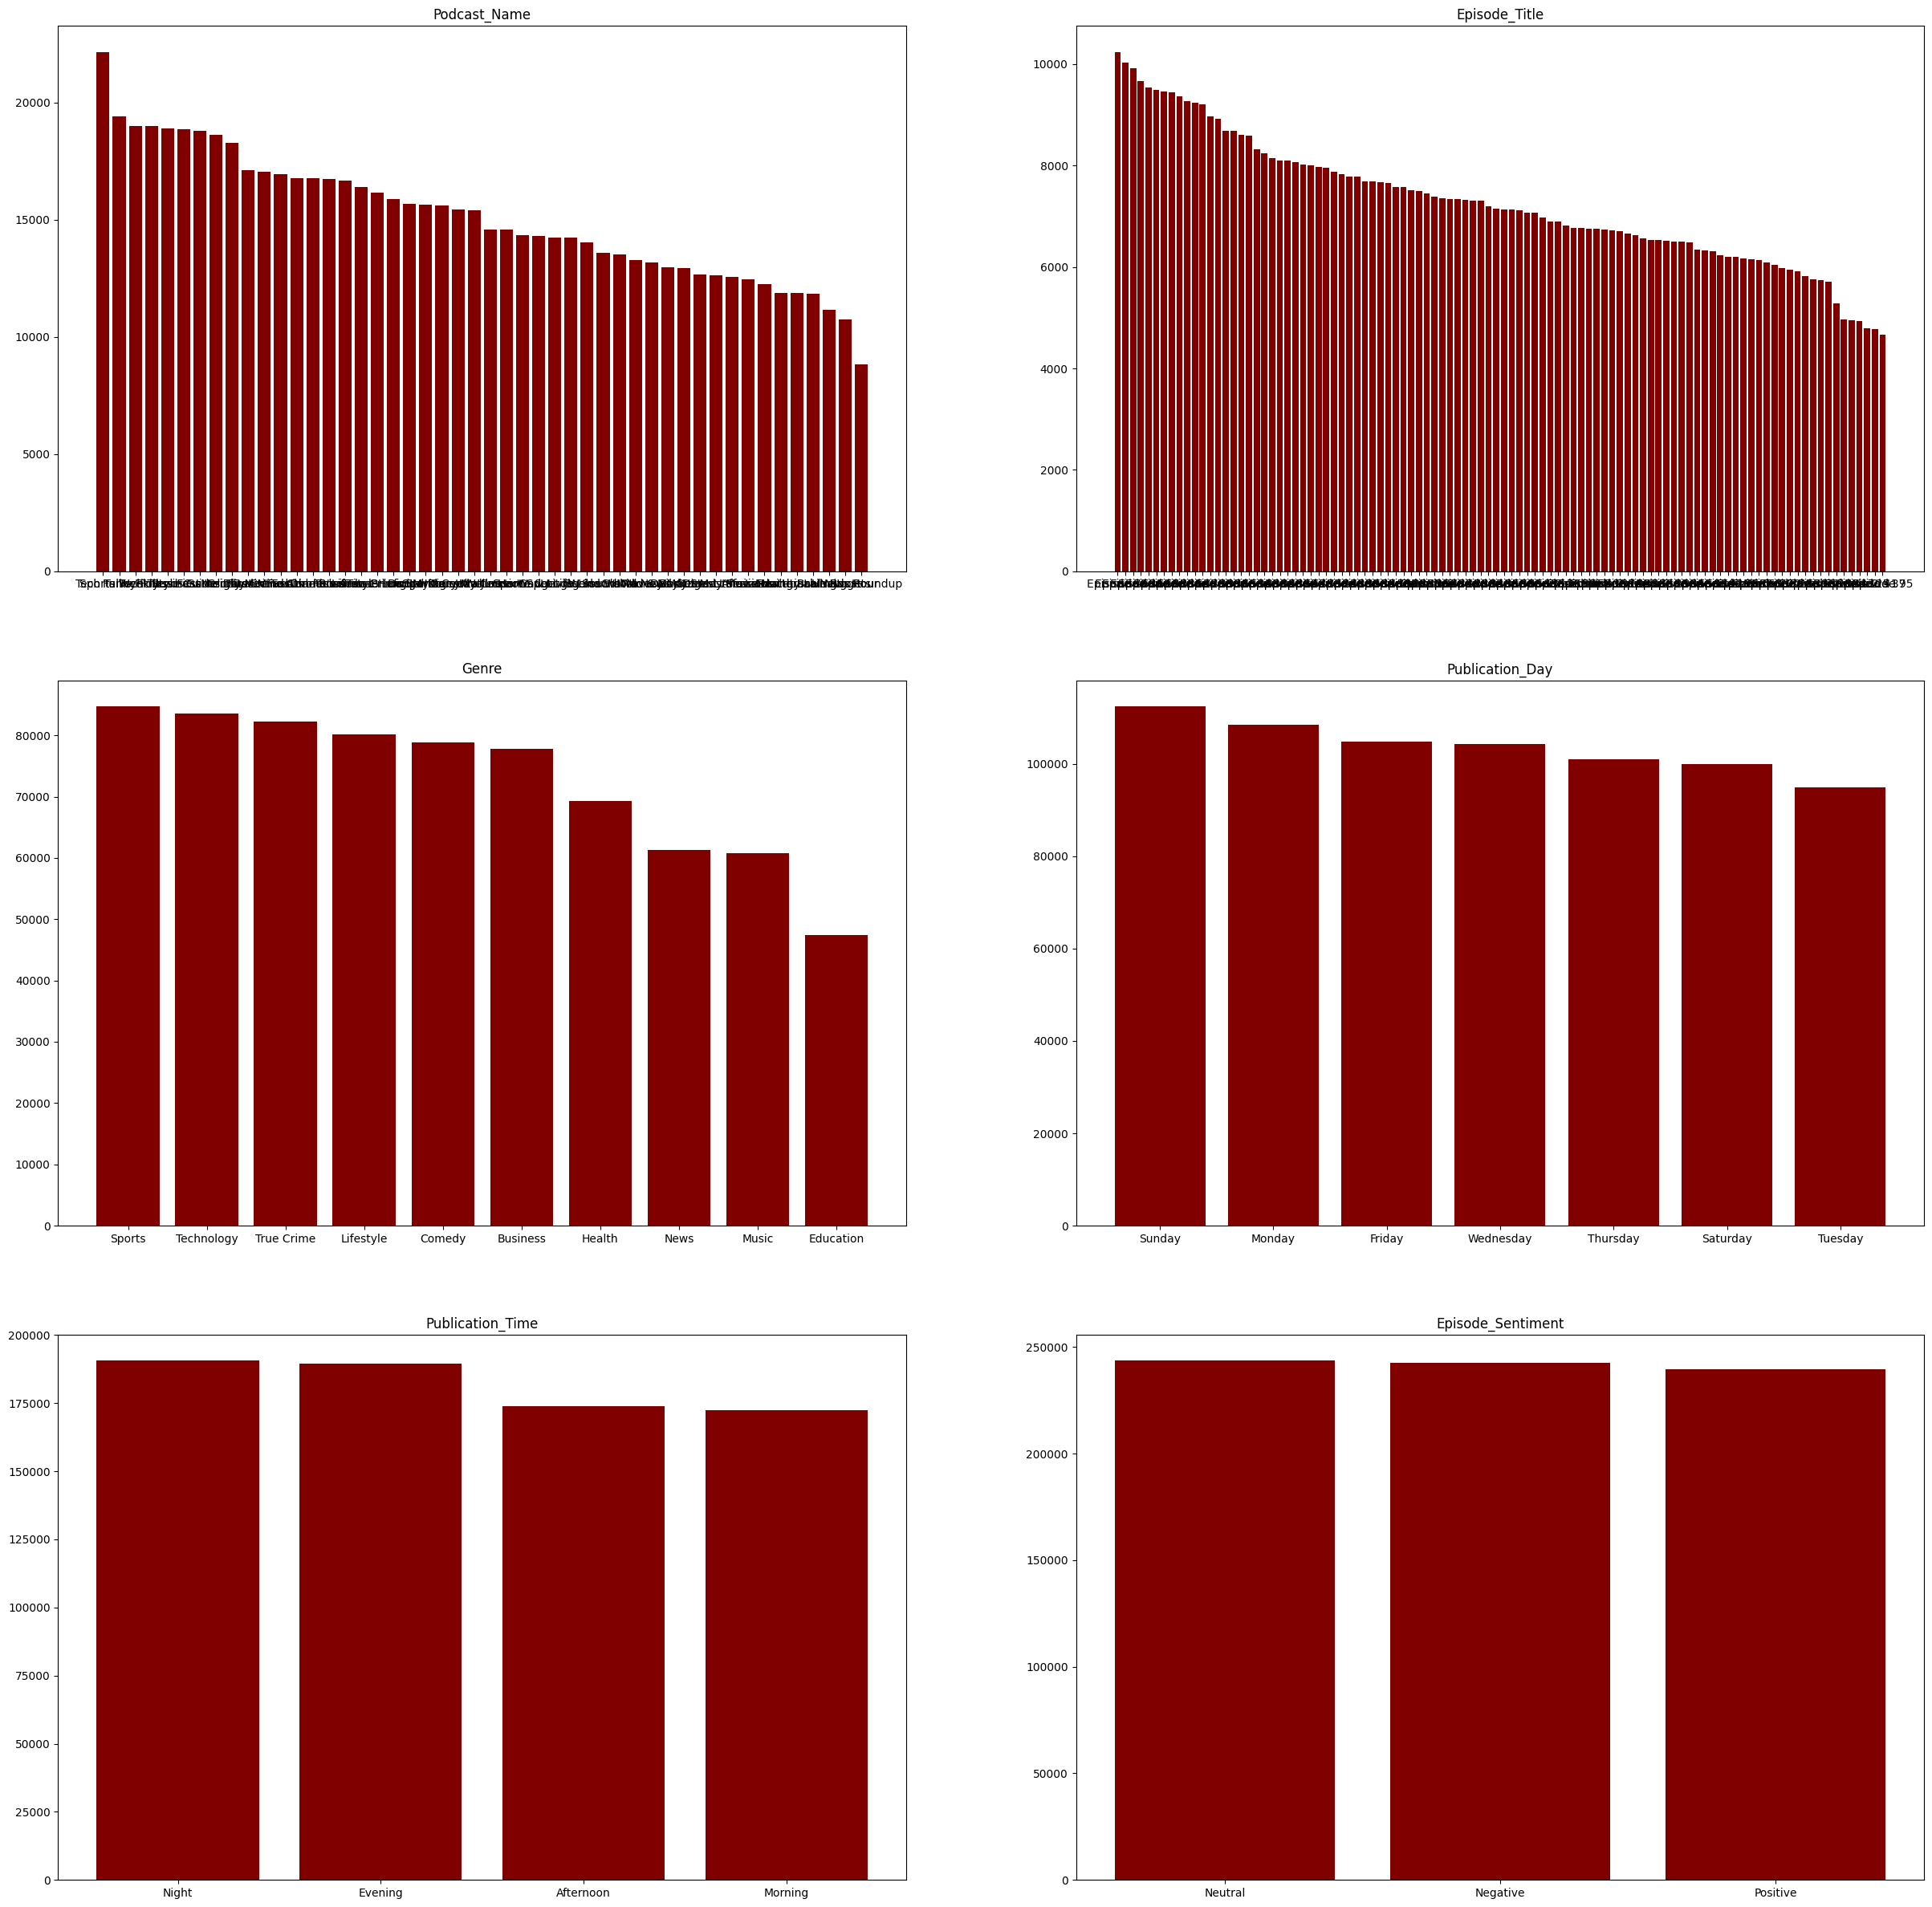

In [48]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(30, 30))
i=0
j=0
# Use the original DataFrame (train_train_df) instead of the string 'train_df'
for cat_column in cat_cols[0:6]:  # Iterate through the first 10 categorical columns
    # Access the data for the current categorical column
    axes[i, j].bar(train_df[cat_column].value_counts().index, train_df[cat_column].value_counts().values, color='maroon')
    axes[i, j].set_title(cat_column)
    if(j<1):
        j+=1
    else:
        i+=1
        j=0
plt.show()

In [27]:
train_df[cat_cols].nunique()
## catigories will be one hot encoded (nominal) [Podcast_Name,Episode_Title,Genre,Podcast_Name]
## catigories will be one label encoded (ordinal) [Publication_Day,Publication_Time,Episode_Sentiment]

,0
Podcast_Name,48
Episode_Title,100
Genre,10
Publication_Day,7
Publication_Time,4
Episode_Sentiment,3


In [28]:
train_df[cat_cols]

,Podcast_Name,Episode_Title,Genre,Publication_Day,Publication_Time,Episode_Sentiment
0,Mystery Matters,Episode 98,True Crime,Thursday,Night,Positive
1,Joke Junction,Episode 26,Comedy,Saturday,Afternoon,Negative
2,Study Sessions,Episode 16,Education,Tuesday,Evening,Negative
3,Digital Digest,Episode 45,Technology,Monday,Morning,Positive
4,Mind & Body,Episode 86,Health,Monday,Afternoon,Neutral
...,...,...,...,...,...,...
749995,Learning Lab,Episode 25,Education,Saturday,Morning,Negative
749996,Business Briefs,Episode 21,Business,Saturday,Night,Neutral
749997,Lifestyle Lounge,Episode 51,Lifestyle,Thursday,Morning,Negative
749998,Style Guide,Episode 47,Lifestyle,Thursday,Morning,Negative


#### Encoding Process

### Target encoding


*   Target encoding is a encoding technique used with catigorical feature with many diffrent values like (podcast name) in our case

*   it uses replaces each category with the avrage of number it count in targer value



In [29]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 114.1 MB/s eta 0:00:00


In [30]:
import category_encoders as ce
target ='Listening_Time_minutes'
target_encode_cols = ['Podcast_Name', 'Genre']
encoder= ce.TargetEncoder(cols=target_encode_cols,smoothing=5.0)

df_encoded = train_df.copy()
df_encoded[target_encode_cols] = encoder.fit_transform(df_encoded[target_encode_cols], df_encoded[target])


In [31]:

episode_sentiment_mapping = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
df_encoded['Episode_Sentiment_encoded'] = df_encoded['Episode_Sentiment'].map(episode_sentiment_mapping)
df_encoded = df_encoded.drop('Episode_Sentiment', axis=1)

In [32]:
df_encoded['Episode_Number'] = df_encoded['Episode_Title'].str.extract(r'(\d+)').astype(float)
df_encoded.drop(columns=['Episode_Title'], inplace=True)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
time_order = ['Morning', 'Afternoon', 'Evening', 'Night']
df_encoded['Publication_Day'] = df_encoded['Publication_Day'].map({day: i for i, day in enumerate(day_order)})
df_encoded['Publication_Time'] = df_encoded['Publication_Time'].map({time: i for i, time in enumerate(time_order)})

df_encoded

,id,Podcast_Name,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes,Episode_Sentiment_encoded,Episode_Number
0,0,45.012590,35.845,45.183599,74.81,3,3,8.230,0.0,31.41998,2,98.0
1,1,41.817799,119.800,43.598834,66.95,5,1,75.950,2.0,88.01241,0,26.0
2,2,46.106793,73.900,44.885625,69.97,1,2,8.970,0.0,44.92531,0,16.0
3,3,43.976254,67.170,44.830069,57.22,0,0,78.700,2.0,46.27824,2,45.0
4,4,45.971112,110.510,44.957410,80.07,0,1,58.680,3.0,75.61031,1,86.0
...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,44.876546,75.660,44.885625,69.36,5,0,51.200,0.0,56.87058,0,25.0
749996,749996,46.143915,75.750,44.582538,35.21,5,3,57.196,2.0,45.46242,1,21.0
749997,749997,44.697256,30.980,44.743431,78.58,3,0,84.890,0.0,15.26000,0,51.0
749998,749998,44.358665,108.980,44.743431,45.39,3,0,93.270,0.0,100.72939,0,47.0


# Model

In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# 1. Define target and features
target = 'Listening_Time_minutes'
# Ensure the target column is present in df_encoded before dropping
if target in df_encoded.columns:
    features = df_encoded.drop(columns=[target, 'id'], axis=1)
else:
    # If target was dropped during encoding, re-add it from original train_df
    df_encoded[target] = train_df[target]
    features = df_encoded.drop(columns=[target, 'id'], axis=1)


# 2. Train/test split using features and target from the encoded DataFrame
X_train, X_val, y_train, y_val = train_test_split(features, df_encoded[target], test_size=0.2, random_state=42)


In [45]:
model = RandomForestRegressor(
    n_estimators=300,
    max_depth=25,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)


RandomForestRegressor(max_depth=25, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=300, n_jobs=-1,
                      random_state=42)

### Evaluation

In [46]:

y_train_pred = model.predict(X_train)
# Calculate MSE and then take the square root for RMSE
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
print(f"Training RMSE: {rmse_train:.4f}")

y_pred = model.predict(X_val)
# Calculate MSE and then take the square root for RMSE
mse_val = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse_val)
print(f"Validation RMSE: {rmse:.4f}")

mae = mean_absolute_error(y_val, y_pred)
print(f"MAE: {mae:.2f} minutes")

print("Mean:", train_df['Listening_Time_minutes'].mean())
print("Std:", train_df['Listening_Time_minutes'].std())

Training RMSE: 7.0248
Validation RMSE: 11.8294
MAE: 8.71 minutes
Mean: 44.5912894526743
Std: 26.866206508126243


### model visualization

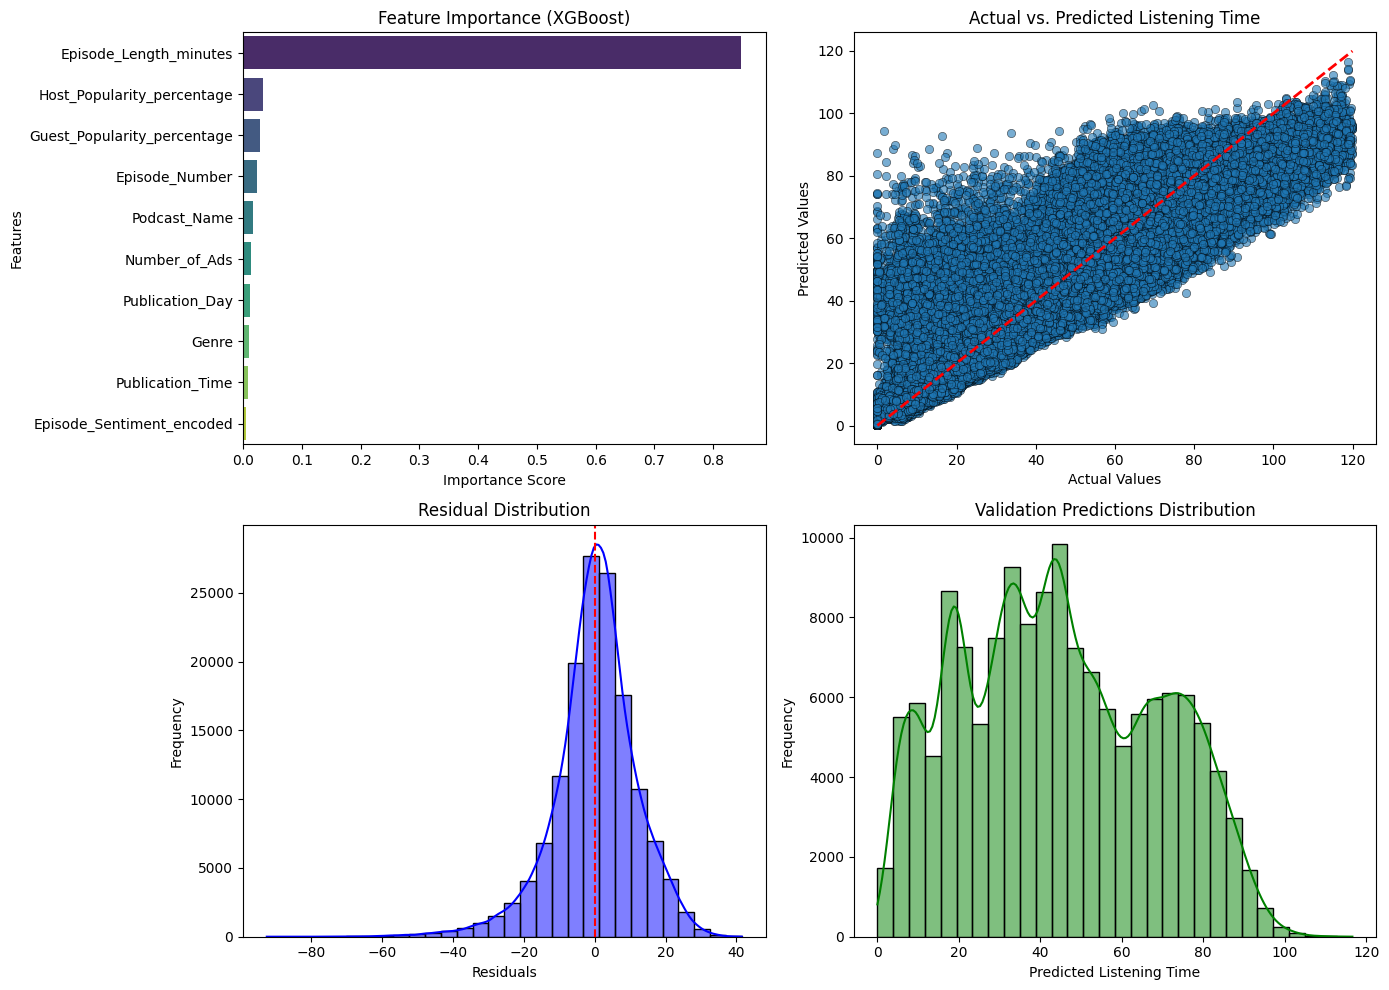

In [47]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

feature_importance = model.feature_importances_
# Corrected 'features' to 'X' to use the defined feature DataFrame
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis", ax=axes[0, 0])
axes[0, 0].set_title("Feature Importance (XGBoost)")
axes[0, 0].set_xlabel("Importance Score")
axes[0, 0].set_ylabel("Features")

# Changed val_pred to y_pred
sns.scatterplot(x=y_val, y=y_pred, alpha=0.6, edgecolors="k", ax=axes[0, 1])
axes[0, 1].plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], '--r', linewidth=2)
axes[0, 1].set_title("Actual vs. Predicted Listening Time")
axes[0, 1].set_xlabel("Actual Values")
axes[0, 1].set_ylabel("Predicted Values")

# Changed val_pred to y_pred
residuals = y_val - y_pred
sns.histplot(residuals, bins=30, kde=True, color='blue', ax=axes[1, 0])
axes[1, 0].axvline(0, color='red', linestyle='--')
axes[1, 0].set_title("Residual Distribution")
axes[1, 0].set_xlabel("Residuals")
axes[1, 0].set_ylabel("Frequency")

# Changed test_preds to y_pred, assuming it's meant to show validation predictions distribution
sns.histplot(y_pred, bins=30, kde=True, color='green', ax=axes[1, 1])
axes[1, 1].set_title("Validation Predictions Distribution") # Updated title to reflect this assumption
axes[1, 1].set_xlabel("Predicted Listening Time")
axes[1, 1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()